<a href="https://colab.research.google.com/github/awhang/pytorch_fundamentals/blob/main/02_neural_network_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02. Neural Network classification with PyTorch

Classification is a problem of predicting whether something is one thing or antoher (e.g. email that is spam or not spam)

## 1. Make classification data and get it ready

We'll be using data from `scikitlearn` that is often referred to as a **toy dataset**, a dataset that is small enough to experiment with but still sizeable enough to practice deep learning fundamentals. 

In [98]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42) # sets the random seed

In [99]:
len(X), len(y)

(1000, 1000)

In [100]:
print(f"This is the first 5 of X:\n {X[:5]}")
print(f"This is the first 5 of y:\n {y[:5]}")

This is the first 5 of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
This is the first 5 of y:
 [1 1 1 1 0]


In [101]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame(data={"X1": X[:, 0],
                             "X2": X[:, 1],
                             "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


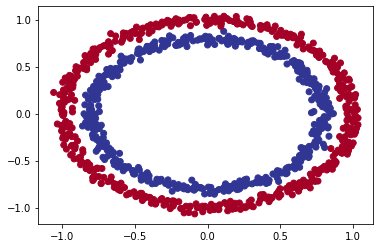

In [102]:
# Plotting to visualize the data
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

In [103]:
# Check the shape of the data
X.shape, y.shape

((1000, 2), (1000,))

In [104]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


In [105]:
import torch
torch.__version__

'1.12.1+cu113'

### 1.2 Turn data into tensors and creating training and testing splits

Will be using `train_test_split` from sklearn 
- Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [106]:
# Convert to tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [107]:
# Create training and test splits
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 0.2 of data will be test and 0.8 will be train
                                                    random_state=42 # sets the random seed
                                                    )

## 2. Building the model

We'll build am odel to classify the blue and red dots.

How to:
1. Setup device agnostic code
2. Construct a model (subclassing `nn.Module`)
3. Define a loss function and optimizer
4. Create training and testing loop

In [108]:
# Import necessary packages
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

In [109]:
# Setting up device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [110]:
# Construct the model

class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()

    # 2 nn.Linear layers capable of handling the shapes of the data
    self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features an upscales to 5 features
    self.layer_2 = nn.Linear(in_features=5, out_features=1) # since layer one produces 5 features, the in_features here has to match
  
  # 3.  Define the forward pass function
  def forward(self, x):
    return self.layer_2(self.layer_1(x))

# 4 Instantiate the model and point to target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [111]:
# We'll re-use the model above but use nn.Sequential() instead

model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [112]:
model_0.state_dict()

OrderedDict([('0.weight', tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]])),
             ('0.bias', tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370])),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]])),
             ('1.bias', tensor([-0.1213]))])

In [113]:
# Make first round of predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"\nFirst 10 predictions:\n{torch.round(untrained_preds[:10])}")
print(f"\nFirst 10 labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])

First 10 predictions:
tensor([[-0.],
        [-0.],
        [0.],
        [-0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [-0.]])

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Set up loss function and optimizer

Which loss function and optimizer should we use?
This depends on the problem or question.
e.g. for regression you might use  MAE or MSE (mean absolute error or mean squared error)
     for classification you might use binary cross entropy or categorical cross entropy

For optimizers: the two most common are SGD and Adam.

In [114]:
# Set up the loss function https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html
loss_fn = nn.BCEWithLogitsLoss() # sigmoid activation function build-in
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)

In [115]:
# Calculate accuracy - out of 100, what percentage does the model get right?

def accuracy(y_true, y_pred) -> int:
  correct = torch.eq(y_true, y_pred).sum().item()
  return correct/len(y_pred) * 100

## 3. Train model

1. Forward Pass
2. Calculate the loss
3. Optimizer zero grad
4. Backpropagation
5. Optimizer step (gradient descent)

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits**

We can convert the logits to prediction probabilities by passing them to some activation function (e.g. sigmoid for binary classificiation and softmax for multiclass classification).in

Then we can convert our model's predicition probabilities to **prediction labels** by either rounding them or taking the argmax().

In [116]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]])

In [117]:
# Use the sigmoid activation function on the logits to turn them into prediction probabilities

y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]])

Perform range-style rounding to convert predictions to classification

  *`y_pred_probs` >= 0.5, `y=1` (class 1)
 
  *`y_pred_probs` < 0.5, `y=0` (class 0)


These ranges are customizable

In [118]:
# Get the predicted labels
y_preds = torch.round(y_pred_probs)

# In full (logits -> pred_probs -> pred_labels)
y_pred_labels = torch.round(
    torch.sigmoid(
        model_0(
            X_test.to(device)
          )[:5]
      )
  )

# Check for equality
print(torch.eq(y_pred_labels.squeeze(), y_preds.squeeze()))



tensor([True, True, True, True, True])


### 3.2 Create the training and testing loop

In [119]:
# The training and testing loop
def train_test_loop(X_train, y_train, X_test, y_test, model, epochs=500, print_step=10, device="cpu", seed=42):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

  # Point data to target device
  X_train, y_train = X_train.to(device), y_train.to(device)
  X_test, y_test = X_test.to(device), y_test.to(device)

  epoch_times = []
  loss = []
  test_loss = []

  for epoch in range(epochs):

    ### Training
    model.train()

    # Forward Pass
    y_logits = model(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred_probs -> pred_labels
    
    # Calculate the loss and accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy(y_train, y_preds)

    # Optimizer zero grad
    optimizer.zero_grad()

    # Backpropagation
    loss.backward()

    # Optimizer step (gradient descent)
    optimizer.step()

    ### Testing
    model.eval()
    with torch.inference_mode():
      # Forward Pass
      test_logits = model(X_test).squeeze()
      test_preds = torch.round(torch.sigmoid(test_logits))

      # Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy(y_test, test_preds)
    
    if epoch % print_step == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}% ")

train_test_loop(X_train, y_train, X_test, y_test, model=model_0, device=device, seed=42)

Epoch: 0 | Loss: 0.69796, Acc: 51.87500 | Test loss: 0.69460, Test acc: 57.50% 
Epoch: 10 | Loss: 0.69768, Acc: 52.00000 | Test loss: 0.69438, Test acc: 58.00% 
Epoch: 20 | Loss: 0.69742, Acc: 52.00000 | Test loss: 0.69418, Test acc: 57.50% 
Epoch: 30 | Loss: 0.69717, Acc: 52.00000 | Test loss: 0.69401, Test acc: 56.50% 
Epoch: 40 | Loss: 0.69695, Acc: 51.62500 | Test loss: 0.69385, Test acc: 56.50% 
Epoch: 50 | Loss: 0.69675, Acc: 51.37500 | Test loss: 0.69370, Test acc: 56.00% 
Epoch: 60 | Loss: 0.69656, Acc: 51.37500 | Test loss: 0.69357, Test acc: 56.00% 
Epoch: 70 | Loss: 0.69638, Acc: 51.37500 | Test loss: 0.69345, Test acc: 56.50% 
Epoch: 80 | Loss: 0.69621, Acc: 51.25000 | Test loss: 0.69334, Test acc: 56.50% 
Epoch: 90 | Loss: 0.69606, Acc: 51.37500 | Test loss: 0.69324, Test acc: 55.00% 
Epoch: 100 | Loss: 0.69592, Acc: 51.12500 | Test loss: 0.69315, Test acc: 54.00% 
Epoch: 110 | Loss: 0.69579, Acc: 51.00000 | Test loss: 0.69306, Test acc: 53.00% 
Epoch: 120 | Loss: 0.69567,

## 4. Make predictions and evaluate the model

This model does not seem to be working.
Let's visualize the results...

In [120]:
import requests
from pathlib import Path

# Let's download some help functions from the Learn Python repo if it isn't already downloaded

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


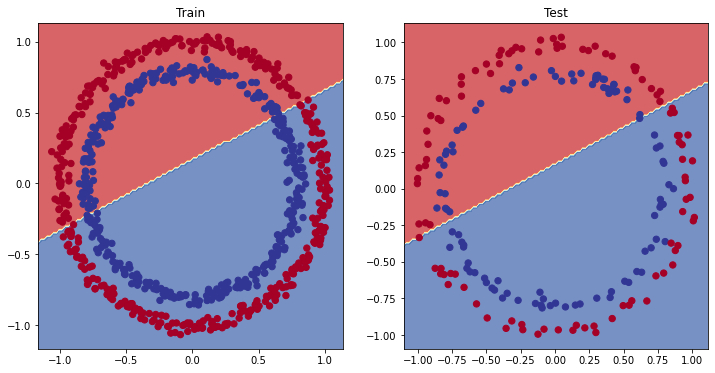

In [121]:
# Plot decision boundary of the model

def plot_test_train(model):
  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2,  1)
  plt.title("Train")
  plot_decision_boundary(model, X_train, y_train)

  plt.subplot(1, 2, 2)
  plt.title("Test")
  plot_decision_boundary(model, X_test, y_test)

plot_test_train(model_0)

## 5. Improve the model

Things to try:
* Add more layers
* Add more hidden units (features)
* Change/add activation functions
* Change the loss/optimizer function
* Increase the number of epochs
* Change the learning rate

These are referred to as hyperparameters

We'll try adding more features, adding a layer, adding ReLu activations and changing the optimizer

These were done one by one, and the combination of both changing the optimizer to Adam and adding ReLU activations made significant improvements.

Adding another linear layer with ReLU activation seemed to create detrimental outcomes.

In [122]:
# We'll try adding ReLu activations and changing the optimizer

model_1 = nn.Sequential(
    nn.Linear(in_features=2, out_features=8),
    nn.ReLU(),
    # nn.Linear(in_features=8, out_features=16), # this layer seemed to cause worse results
    # nn.ReLU(),
    nn.Linear(in_features=8, out_features=1),
).to(device)

loss_fn = nn.BCEWithLogitsLoss() # sigmoid activation function build-in
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.01)

# Try out the new model
train_test_loop(X_train, y_train, X_test, y_test, epochs=500, print_step=10, model=model_1, device=device, seed=42)

Epoch: 0 | Loss: 0.69735, Acc: 48.75000 | Test loss: 0.68901, Test acc: 53.00% 
Epoch: 10 | Loss: 0.68823, Acc: 52.37500 | Test loss: 0.68268, Test acc: 54.50% 
Epoch: 20 | Loss: 0.68156, Acc: 52.12500 | Test loss: 0.67588, Test acc: 55.00% 
Epoch: 30 | Loss: 0.67452, Acc: 57.12500 | Test loss: 0.66887, Test acc: 67.00% 
Epoch: 40 | Loss: 0.66391, Acc: 66.00000 | Test loss: 0.66030, Test acc: 70.00% 
Epoch: 50 | Loss: 0.65007, Acc: 76.00000 | Test loss: 0.65003, Test acc: 76.00% 
Epoch: 60 | Loss: 0.63329, Acc: 87.87500 | Test loss: 0.63822, Test acc: 82.00% 
Epoch: 70 | Loss: 0.61443, Acc: 87.87500 | Test loss: 0.62351, Test acc: 81.50% 
Epoch: 80 | Loss: 0.59357, Acc: 92.00000 | Test loss: 0.60520, Test acc: 84.50% 
Epoch: 90 | Loss: 0.57048, Acc: 93.00000 | Test loss: 0.58308, Test acc: 87.50% 
Epoch: 100 | Loss: 0.54605, Acc: 94.50000 | Test loss: 0.55962, Test acc: 92.00% 
Epoch: 110 | Loss: 0.52107, Acc: 95.50000 | Test loss: 0.53563, Test acc: 92.00% 
Epoch: 120 | Loss: 0.49613,

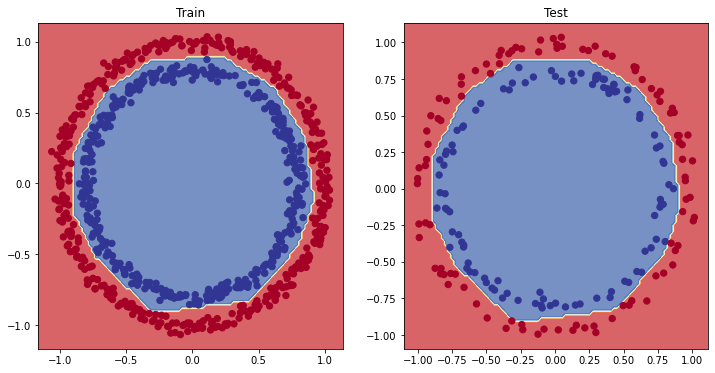

In [123]:
# Plot the results
plot_test_train(model_1)

## 6. Let's try a multi-class classification problem

### 6.1 Creating the toy multi-class datset

In [137]:
# Import dependencies
import torch 
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

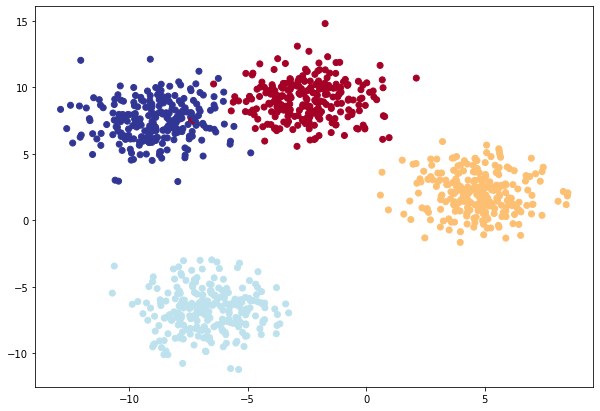

In [143]:
# Set hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5, # gives a little jitter to the data
                            random_state=RANDOM_SEED)

# 2. Convert data to tensors
# Change y dtypes to torch.LongTensor to match expected prediction dtypes later on from torch.argmax
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

### 6.2 Building a multi-class classification model in PyTorch

In [144]:
# Setting up device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [156]:
# Construct the model

# We'll re-use the model above but use nn.Sequential() instead
class BlobModelV0(nn.Module):
  def __init__(self, in_features, out_features, hidden_units=8):
    super().__init__()

    # 2 nn.Linear layers capable of handling the shapes of the data
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=in_features, out_features=hidden_units),
        # nn.ReLU(), # for this mock data set,, ReLU activations seem unnecessary
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        # nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=out_features)
        )
  
  # 3.  Define the forward pass function
  def forward(self, x):
    return self.linear_layer_stack(x)

model_multi = BlobModelV0(in_features=2, # matches number of features in x
                          out_features=4, # matches the number of classes in the blob
                          ).to(device)
model_multi

BlobModelV0(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [157]:
X_blob_train.shape, y_blob_train[:5]

(torch.Size([800, 2]), tensor([1, 0, 2, 2, 0]))

### 6.3 Creating the loss function and optimizer for a multi-class classification

In order to evaluate, train, and test the model, we need to convert our model's outputs (logits) to prediction probabilities and then to prediction labels.

Logits -> Pred probs -> Pred labels

- Here we'll use [`torch.softmax`](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) to convert the logits to probabilities
- To convert the probablities to prediction labels, we can use `torch.argmax`
- You may skip the use of softmax, and just use argmax for similar effect

In [158]:
# Let's test the model quickly with test data

model_multi.eval()
with torch.inference_mode():
  y_logits = model_multi(X_blob_test.to(device))

y_logits[:5]

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852]])

In [159]:
# Converting model's logits to prediction probabilities

y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:5]

tensor([[0.1872, 0.2918, 0.1495, 0.3715],
        [0.2824, 0.0149, 0.2881, 0.4147],
        [0.3380, 0.0778, 0.4854, 0.0989],
        [0.2118, 0.3246, 0.1889, 0.2748],
        [0.1945, 0.0598, 0.1506, 0.5951]])

In [160]:
# Convert prediction probabilities to prediction labels

y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([3, 3, 2, 1, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2,
        2, 2, 3, 3, 3, 3, 3, 1, 1, 2, 1, 2, 1, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3,
        3, 3, 1, 3, 3, 1, 3, 2, 3, 1, 3, 2, 2, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 3, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 3, 3, 2, 3, 3, 3, 3, 2, 3, 1, 3, 3, 2, 1, 1, 3, 2, 2, 3, 3, 3, 1, 2,
        2, 3, 3, 1, 2, 3, 3, 3, 2, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 1, 1, 3, 2, 2,
        2, 2, 3, 3, 3, 2, 2, 1, 3, 2, 3, 3, 3, 3, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3,
        2, 2, 2, 3, 3, 1, 1, 1, 1, 1, 3, 1, 3, 2, 2, 3, 2, 2, 3, 3, 2, 2, 3, 3,
        1, 3, 2, 3, 3, 1, 2, 3])

In [161]:
y_preds_2 = torch.argmax(y_logits, dim=1) # does not seem to need softmax first
y_preds_2

tensor([3, 3, 2, 1, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2,
        2, 2, 3, 3, 3, 3, 3, 1, 1, 2, 1, 2, 1, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3,
        3, 3, 1, 3, 3, 1, 3, 2, 3, 1, 3, 2, 2, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 3, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 3, 3, 2, 3, 3, 3, 3, 2, 3, 1, 3, 3, 2, 1, 1, 3, 2, 2, 3, 3, 3, 1, 2,
        2, 3, 3, 1, 2, 3, 3, 3, 2, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 1, 1, 3, 2, 2,
        2, 2, 3, 3, 3, 2, 2, 1, 3, 2, 3, 3, 3, 3, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3,
        2, 2, 2, 3, 3, 1, 1, 1, 1, 1, 3, 1, 3, 2, 2, 3, 2, 2, 3, 3, 2, 2, 3, 3,
        1, 3, 2, 3, 3, 1, 2, 3])

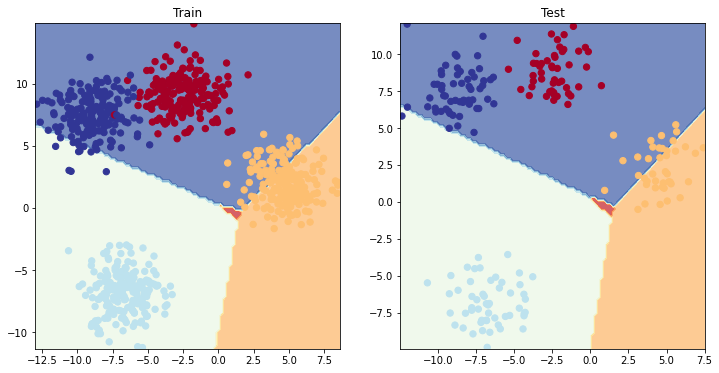

In [162]:
# Let's plot the test run of the model

def plot_test_train(model, X_train, y_train, X_test, y_test):
  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2,  1)
  plt.title("Train")
  plot_decision_boundary(model, X_train, y_train)

  plt.subplot(1, 2, 2)
  plt.title("Test")
  plot_decision_boundary(model, X_test, y_test)

plot_test_train(model_multi, X_blob_train, y_blob_train, X_blob_test, y_blob_test)

In [163]:
# Defining Loss function and Optimizer
loss_fn = nn.CrossEntropyLoss() # loss function often used for multi-class classication https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
optimizer = torch.optim.Adam(params=model_multi.parameters(), lr=0.01)


In [164]:
# The training and testing loop
def train_test_multi_loop(X_train, y_train, X_test, y_test, model, epochs=500, print_step=10, device="cpu", seed=42):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

  # Point data to target device
  X_train, y_train = X_train.to(device), y_train.to(device)
  X_test, y_test = X_test.to(device), y_test.to(device)

  epoch_times = []
  loss = []
  test_loss = []

  for epoch in range(epochs):

    ### Training
    model.train()

    # Forward Pass
    y_logits = model(X_train)
    y_preds = torch.argmax(y_logits, dim=1) # turn logits -> pred_probs -> pred_labels
    
    # Calculate the loss and accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy(y_train, y_preds)

    # Optimizer zero grad
    optimizer.zero_grad()

    # Backpropagation
    loss.backward()

    # Optimizer step (gradient descent)
    optimizer.step()

    ### Testing
    model.eval()
    with torch.inference_mode():
      # Forward Pass
      test_logits = model(X_test)
      test_preds = torch.argmax(test_logits, dim=1)

      # Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy(y_test, test_preds)
    
    if epoch % print_step == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}% ")


In [165]:
# Try out the model
train_test_multi_loop(X_blob_train, y_blob_train, X_blob_test, y_blob_test, epochs=500, print_step=10, model=model_multi, device=device, seed=42)

Epoch: 0 | Loss: 1.04324, Acc: 65.50000 | Test loss: 0.84577, Test acc: 74.00% 
Epoch: 10 | Loss: 0.17839, Acc: 98.87500 | Test loss: 0.15055, Test acc: 99.50% 
Epoch: 20 | Loss: 0.05535, Acc: 99.37500 | Test loss: 0.04468, Test acc: 99.50% 
Epoch: 30 | Loss: 0.03312, Acc: 99.25000 | Test loss: 0.02467, Test acc: 99.50% 
Epoch: 40 | Loss: 0.02753, Acc: 99.25000 | Test loss: 0.01741, Test acc: 99.50% 
Epoch: 50 | Loss: 0.02552, Acc: 99.37500 | Test loss: 0.01505, Test acc: 99.50% 
Epoch: 60 | Loss: 0.02455, Acc: 99.37500 | Test loss: 0.01417, Test acc: 99.50% 
Epoch: 70 | Loss: 0.02393, Acc: 99.50000 | Test loss: 0.01341, Test acc: 99.50% 
Epoch: 80 | Loss: 0.02344, Acc: 99.50000 | Test loss: 0.01272, Test acc: 99.50% 
Epoch: 90 | Loss: 0.02304, Acc: 99.50000 | Test loss: 0.01216, Test acc: 99.50% 
Epoch: 100 | Loss: 0.02268, Acc: 99.50000 | Test loss: 0.01170, Test acc: 99.50% 
Epoch: 110 | Loss: 0.02235, Acc: 99.50000 | Test loss: 0.01129, Test acc: 99.50% 
Epoch: 120 | Loss: 0.02204,

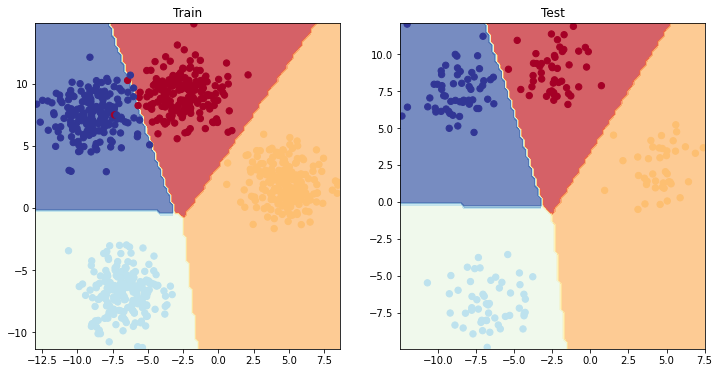

In [166]:
# Plot decision boundary of the model

def plot_test_train_multi(model, X_train, y_train, X_test, y_test):
  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2,  1)
  plt.title("Train")
  plot_decision_boundary(model, X_train, y_train)

  plt.subplot(1, 2, 2)
  plt.title("Test")
  plot_decision_boundary(model, X_test, y_test)

plot_test_train_multi(model_multi, X_blob_train, y_blob_train, X_blob_test, y_blob_test)

### 7. Other classification metrics to evaluate the model
- Accuracy
- Precision
- Recall
- F1-score - combination of precision and recall
- Confusion matrix
- Classification report

See [article](https://towardsdatascience.com/beyond-accuracy-other-classification-metrics-you-should-know-in-machine-learning-ea671be83bb7) for when to use precision or recall

Also look into using PyTorch's [`torchmetrics`](https://torchmetrics.readthedocs.io/en/stable/classification/accuracy.html)